# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.831041,False,0.963584
1,0.812287,True,7.432452
2,-1.639416,False,-0.215784
3,0.024691,False,1.124566
4,-1.060961,False,0.436120
...,...,...,...
995,-1.313231,False,-1.864363
996,-1.099555,False,0.711327
997,-1.150180,False,-1.391543
998,-0.985048,False,-0.080119


<Axes: xlabel='v0'>

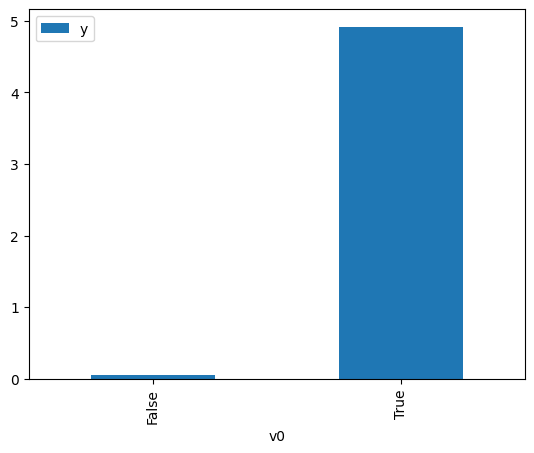

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

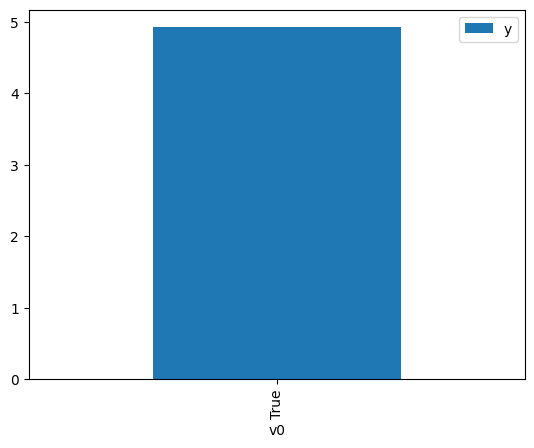

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.541920,False,0.230269,0.722869,1.383376
1,-1.312100,False,0.213642,0.916890,1.090643
2,-2.666825,False,-2.649369,0.992878,1.007173
3,-1.042077,False,-0.910359,0.869351,1.150283
4,0.559026,False,-0.477228,0.249238,4.012222
...,...,...,...,...,...
995,-0.399193,False,-0.317042,0.666300,1.500827
996,-1.062465,False,0.411092,0.873626,1.144654
997,-0.932467,False,-0.560046,0.844224,1.184519
998,-0.149091,False,-0.325026,0.555571,1.799951


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.021499,True,5.564104,0.135088,7.402603
1,-1.343658,True,5.433499,0.078716,12.703842
2,0.722241,True,4.293171,0.803495,1.244563
3,-1.263921,True,4.930265,0.090247,11.080643
4,-1.929117,True,4.099727,0.027757,36.027473
...,...,...,...,...,...
995,-1.929117,True,4.099727,0.027757,36.027473
996,0.810213,True,2.827785,0.828211,1.207422
997,0.861627,True,4.230695,0.841478,1.188385
998,0.128375,True,6.492101,0.573544,1.743546


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              4964.
Date:                Mon, 20 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:27:35   Log-Likelihood:                         -1415.6
No. Observations:                1000   AIC:                                      2835.
Df Residuals:                     998   BIC:                                      2845.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0797      0.030      2.643      0.008       0.021       0.139
x2             4.9816      0.051     97.416      0.000       4.881       5.082
==============================================================================
Omnibus:                        5.517   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.532
Skew:                           0.163   Prob(JB):                       0.0629
Kurtosis:                       2.838   Cond. No.                         1.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""